In [3]:
! echo "--- Visible GPUs ---"; rocm-smi --showid;  echo ""; echo "--- Visible CPUs ---"; echo "CPUs available to this process: $(nproc)"; echo ""; echo "--- Visible Memory (RAM) ---"; free -h;

--- Visible GPUs ---
cat: /sys/module/amdgpu/initstate: No such file or directory
ERROR:root:Driver not initialized (amdgpu not found in modules)
/bin/bash: line 1: $'\302\240': command not found
--- Visible CPUs ---
CPUs available to this process: 128

--- Visible Memory (RAM) ---
               total        used        free      shared  buff/cache   available
Mem:           250Gi       6.4Gi       244Gi       410Mi       1.2Gi       244Gi
Swap:             0B          0B          0B


In [5]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import sklearn as skl
from tensorflow import keras
from tensorflow.keras import layers

In [6]:
def load_snp_csv(snp_file):
    df = pd.read_csv(snp_file)  # do NOT use index_col=0 here
    df.rename(columns={df.columns[0]: 'GID'}, inplace=True)  # First column is GID
    df = df.astype(float, errors='ignore')  # Only SNPs will be float
    return df

class MultiModalDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, image_path, geno_feature_cols, batch_size=32, shuffle=True):
        self.df = dataframe.reset_index(drop=True)
        self.image_path = image_path
        self.geno_feature_cols = geno_feature_cols
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_df = self.df.iloc[index * self.batch_size : (index + 1) * self.batch_size]
        
        X_img = []
        X_geno = []
        Y = []
        
        for _, row in batch_df.iterrows():
            # Load image
            img = np.load(os.path.join(self.image_path, row['Filename']))
            X_img.append(img)

            # Genomic features
            geno = row[self.geno_feature_cols].values.astype(np.float32)
            X_geno.append(geno)

            # Yield
            Y.append(row['GRYLD'])

        return [np.array(X_img), np.array(X_geno)], np.array(Y)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [7]:
geno_df = load_snp_csv("SNPs_phased_reduced.csv")

In [8]:
csv_path = "/scratch/pawsey1157/rtrivedi/dataset/Phenotypes/Images_GIDs_GRYLD.csv"
img_df = pd.read_csv(csv_path, header=None, names=['Filename', 'GID', 'GRYLD'])

In [9]:
from sklearn.model_selection import train_test_split

# Load data
#geno_df = pd.read_csv('SNPs_phased_reduced.csv')
#img_df = pd.read_csv('Images_GIDs_GRYLD.csv')

# Reset index to make GID a column again
#geno_df_reset = geno_df.reset_index()

merged_df = pd.merge(img_df, geno_df, on='GID')

# Drop any NaNs
merged_df = merged_df.dropna(subset=['GRYLD'])

# Define genomic columns
geno_feature_cols = [col for col in merged_df.columns if col not in ['GID', 'Filename', 'GRYLD']]

image_path = "/scratch/pawsey1157/rtrivedi/dataset/Phenotypes/stacked_npy/"

#train_df, val_df = train_test_split(merged_df, test_size=0.2, random_state=42)

# Extract unique GIDs
unique_gids = merged_df['GID'].unique()

# Train/test split on GIDs
train_gids, val_gids = train_test_split(unique_gids, test_size=0.3, random_state=42)

# Subset the full dataframe based on GIDs
train_df = merged_df[merged_df['GID'].isin(train_gids)].reset_index(drop=True)
val_df = merged_df[merged_df['GID'].isin(val_gids)].reset_index(drop=True)

# Create generator
train_gen = MultiModalDataGenerator(
    dataframe=train_df,
    image_path=image_path,
    geno_feature_cols=geno_feature_cols,
    batch_size=32,
    shuffle=True
)

val_gen = MultiModalDataGenerator(
    dataframe=val_df,
    image_path=image_path,
    geno_feature_cols=geno_feature_cols,
    batch_size=32,
    shuffle=False  # don't shuffle validation
)

In [9]:
# Alignment check

# Display a few rows to check alignment
sample = merged_df.sample(1).iloc[0]
print(f"GID: {sample['GID']}")
print(f"Filename: {sample['Filename']}")
print(f"Yield (GRYLD): {sample['GRYLD']:.3f}")

# Check genotype vector
geno_vector = sample[geno_feature_cols].values
print(f"Genotype shape: {geno_vector.shape}")
print(f"Non-zero SNPs: {(geno_vector != 0).sum()}, Mean: {geno_vector.mean():.4f}")

GID: GID8248483
Filename: 18-OBR-YTBW-B5I-29804-20180321_210230_IMG_0729_1.npy
Yield (GRYLD): 7.650
Genotype shape: (84322,)
Non-zero SNPs: 12236, Mean: 0.1364


In [6]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate

# Load and rename image model
image_model = load_model('CNN.h5', compile=False)
image_model._name = 'image_model'  # Rename to avoid name clash

# Load and rename genotype model
geno_model = load_model('wheat_height_predictor.h5', compile=False)
geno_model._name = 'geno_model'  # Rename to avoid name clash

# Freeze both models
for layer in image_model.layers:
    layer.trainable = False
for layer in geno_model.layers:
    layer.trainable = False

# Define new inputs
img_input = Input(shape=image_model.input_shape[1:], name='image_input')
geno_input = Input(shape=geno_model.input_shape[1:], name='geno_input')

# Pass through models
img_features = image_model(img_input)
geno_features = geno_model(geno_input)

# Combine
fusion = concatenate([img_features, geno_features], name='fusion')
x = layers.Dense(128, activation='relu', name='fusion_dense_1')(fusion)
x = layers.Dropout(0.3, name='fusion_dropout_1')(x)
x = layers.Dense(64, activation='relu', name='fusion_dense_2')(x)
x = layers.Dropout(0.2, name='fusion_dropout_2')(x)
output = layers.Dense(1, activation='relu', name='yield_output')(x)   # setting this to 2 makes the model produce two outputs - incompatible with downstream analysis

# Final model
fusion_model = Model(inputs=[img_input, geno_input], outputs=output)
fusion_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [8]:
#mini model

history = fusion_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    steps_per_epoch=100,        
    validation_steps=40,      
    verbose=1
)

Epoch 1/20
100/100 [==============================] - 136s 1s/step - loss: 7.4717 - mae: 1.9526 - val_loss: 0.8022 - val_mae: 0.7913
Epoch 2/20
100/100 [==============================] - 133s 1s/step - loss: 1.6192 - mae: 1.0175 - val_loss: 0.5931 - val_mae: 0.6728
Epoch 3/20
100/100 [==============================] - 137s 1s/step - loss: 1.1983 - mae: 0.8679 - val_loss: 0.6921 - val_mae: 0.7475
Epoch 4/20
100/100 [==============================] - 130s 1s/step - loss: 1.0858 - mae: 0.8279 - val_loss: 0.3570 - val_mae: 0.4999
Epoch 5/20
100/100 [==============================] - 131s 1s/step - loss: 1.0305 - mae: 0.8096 - val_loss: 0.3280 - val_mae: 0.4750
Epoch 6/20
100/100 [==============================] - 131s 1s/step - loss: 0.9261 - mae: 0.7688 - val_loss: 0.2764 - val_mae: 0.4257
Epoch 7/20
100/100 [==============================] - 135s 1s/step - loss: 0.9020 - mae: 0.7570 - val_loss: 0.7087 - val_mae: 0.7703
Epoch 8/20
100/100 [==============================] - 135s 1s/step - 

In [7]:
history = fusion_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,         
    verbose=1
)

Epoch 1/20
3831/3831 [==============================] - 4796s 1s/step - loss: 0.9171 - mae: 0.7215 - val_loss: 0.1651 - val_mae: 0.3158
Epoch 2/20
3831/3831 [==============================] - 4913s 1s/step - loss: 0.4306 - mae: 0.5161 - val_loss: 0.1437 - val_mae: 0.2929
Epoch 3/20
3831/3831 [==============================] - 4796s 1s/step - loss: 0.3323 - mae: 0.4518 - val_loss: 0.1081 - val_mae: 0.2346
Epoch 4/20
3831/3831 [==============================] - 4806s 1s/step - loss: 0.2580 - mae: 0.3951 - val_loss: 0.0976 - val_mae: 0.2227
Epoch 5/20
3831/3831 [==============================] - 4797s 1s/step - loss: 0.2073 - mae: 0.3505 - val_loss: 0.0932 - val_mae: 0.2123
Epoch 6/20
3831/3831 [==============================] - 4848s 1s/step - loss: 0.1713 - mae: 0.3164 - val_loss: 0.0952 - val_mae: 0.2152
Epoch 7/20
3831/3831 [==============================] - 4822s 1s/step - loss: 0.1491 - mae: 0.2930 - val_loss: 0.0820 - val_mae: 0.1973
Epoch 8/20
3831/3831 [==========================

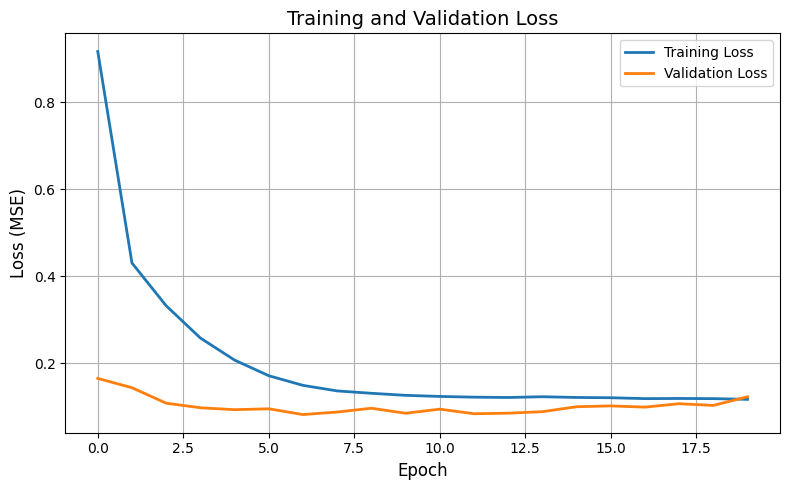

In [8]:
import matplotlib.pyplot as plt

# Assuming 'history' is the result from model.fit()
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# Disable shuffling in train_gen to make it deterministic
train_gen.shuffle = False
train_gen.on_epoch_end()  # Re-shuffle once manually if needed

# Predict on the whole generator
y_pred_train = fusion_model.predict(train_gen, verbose=1)

# Collect y_true **in sync**
y_true_train = []
for i in range(len(train_gen)):
    _, y = train_gen[i]
    y_true_train.append(y)
y_true_train = np.concatenate(y_true_train)

# Compute R²
from sklearn.metrics import r2_score
r2_train = r2_score(y_true_train, y_pred_train)
print(f"R² score (synced): {r2_train:.4f}")

3831/3831 [==============================] - 3401s 888ms/step
R² score (synced): 0.7731


In [10]:
from sklearn.metrics import r2_score

y_pred_val = fusion_model.predict(val_gen)
y_true_val = np.concatenate([y for _, y in val_gen])

r2_val = r2_score(y_true_val, y_pred_val)
print(f"Validation R²: {r2_val:.4f}")

1554/1554 [==============================] - 1383s 890ms/step
Validation R²: 0.7554


In [11]:
fusion_model.save('Multimodal.h5')

/usr/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
print("Predicted range:", y_pred_train.min(), "to", y_pred_train.max())
print("True range:", y_true_train.min(), "to", y_true_train.max())

Predicted range: 5.3781013 to 10.13074
True range: 3.977 to 10.055


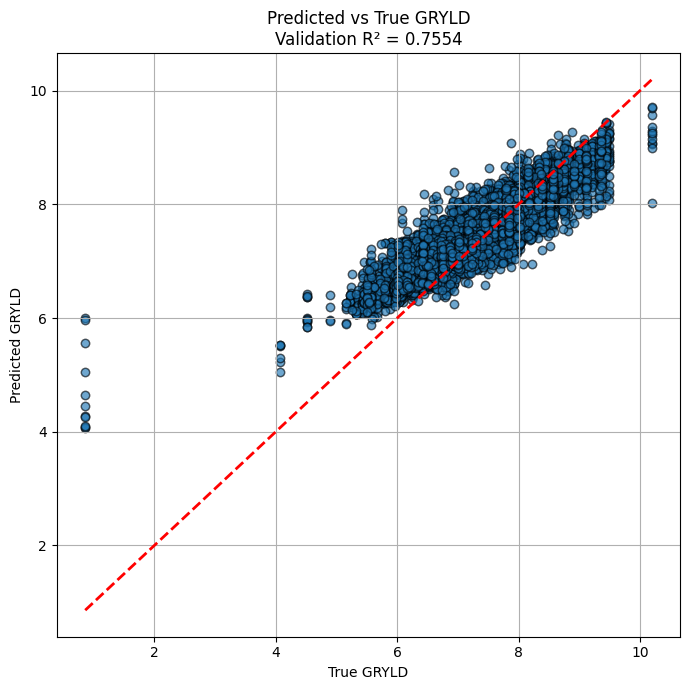

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.scatter(y_true_val, y_pred_val, alpha=0.4, edgecolors='k')
plt.plot([y_true_val.min(), y_true_val.max()],
         [y_true_val.min(), y_true_val.max()],
         'r--', linewidth=2)
plt.xlabel('True GRYLD')
plt.ylabel('Predicted GRYLD')
plt.title(f'Predicted vs True GRYLD\nValidation R² = {r2_val:.4f}')
plt.grid(True)
plt.tight_layout()
plt.show()

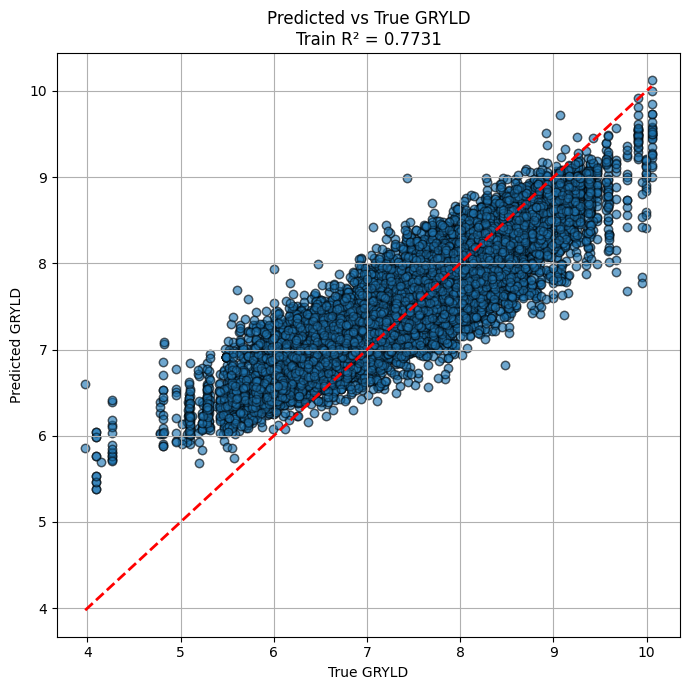

In [14]:
plt.figure(figsize=(7,7))
plt.scatter(y_true_train, y_pred_train, alpha=0.4, edgecolors='k')
plt.plot([y_true_train.min(), y_true_train.max()],
         [y_true_train.min(), y_true_train.max()],
         'r--', linewidth=2)
plt.xlabel('True GRYLD')
plt.ylabel('Predicted GRYLD')
plt.title(f'Predicted vs True GRYLD\nTrain R² = {r2_train:.4f}')
plt.grid(True)
plt.tight_layout()
plt.show()

In [3]:
from tensorflow.keras.models import load_model
fusion_model = load_model("Multimodal.h5")

In [11]:
##### import shap
import numpy as np

# -----------------------
# Prepare background data
# -----------------------
# We can't take it from generators directly, so let's grab arrays from DataFrame
def get_data_from_df(df, image_path, geno_cols, max_samples=None):
    imgs = []
    genos = []
    for i, row in df.iterrows():
        if max_samples and i >= max_samples:
            break
        imgs.append(np.load(os.path.join(image_path, row['Filename'])))
        genos.append(row[geno_cols].values.astype(np.float32))
    return np.array(imgs), np.array(genos)

# Background: small random subset for speed
bg_imgs, bg_genos = get_data_from_df(train_df, image_path, geno_feature_cols, max_samples=200)

# Test samples: also small subset for demonstration
test_imgs, test_genos = get_data_from_df(val_df, image_path, geno_feature_cols, max_samples=40)

In [13]:
import shap

# -----------------------
# Run SHAP
# -----------------------
explainer = shap.GradientExplainer(fusion_model, [bg_imgs, bg_genos])

# Get SHAP values for both inputs
shap_values = explainer.shap_values([test_imgs, test_genos])

# shap_values is a list: shap_values[0] → image input SHAPs, shap_values[1] → SNP input SHAPs
print("Image SHAP shape:", np.array(shap_values[0]).shape)
print("SNP SHAP shape:", np.array(shap_values[1]).shape)

/software/projects/pawsey1157/rtrivedi/setonix/pythonEnvironments/tensorflowContainer_env/machinelearning/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


Image SHAP shape: (40, 145, 61, 8, 1)
SNP SHAP shape: (40, 84322, 1)


/tmp/ipykernel_1840110/2862835376.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_geno, test_genos, feature_names=geno_feature_cols)


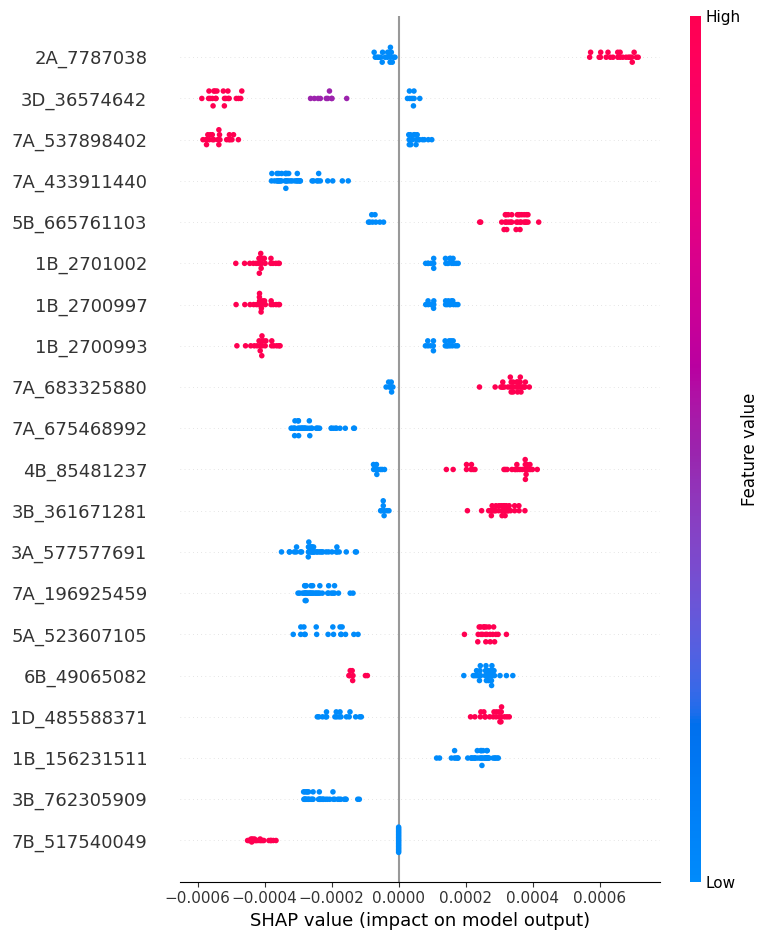

In [16]:
# -----------------------
# Plot SNP SHAP summary
# -----------------------

shap_values_geno = np.squeeze(shap_values[1])
shap.summary_plot(shap_values_geno, test_genos, feature_names=geno_feature_cols)


(145, 61, 8)
(145, 61)


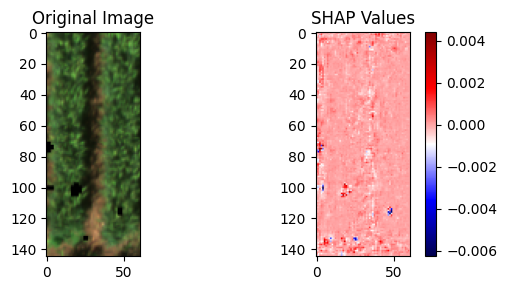

(145, 61, 8)
(145, 61)


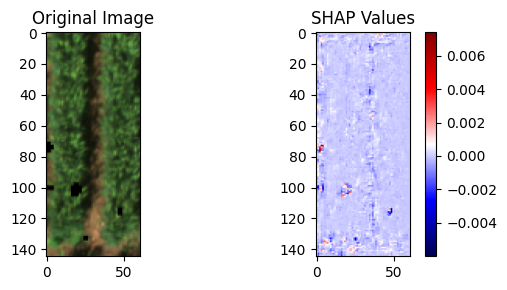

(145, 61, 8)
(145, 61)


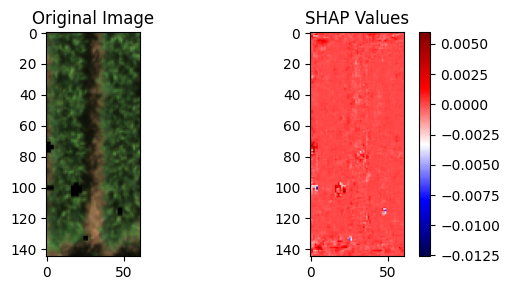

(145, 61, 8)
(145, 61)


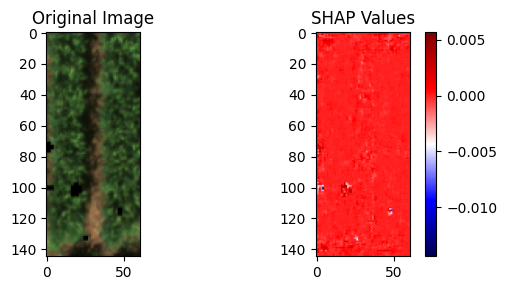

(145, 61, 8)
(145, 61)


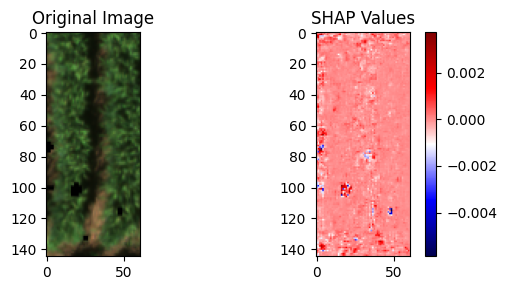

(145, 61, 8)
(145, 61)


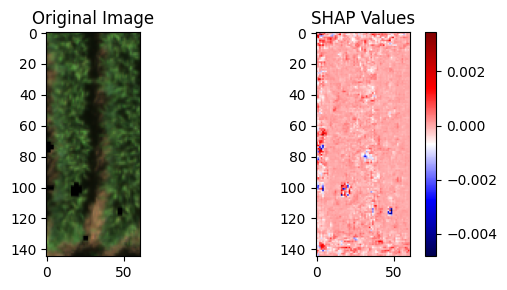

(145, 61, 8)
(145, 61)


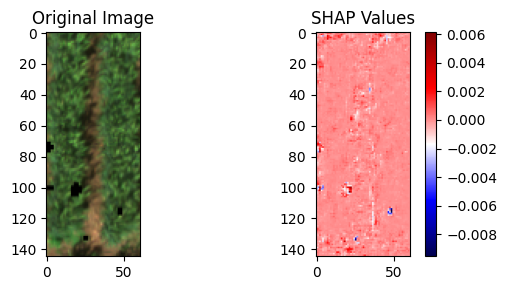

(145, 61, 8)
(145, 61)


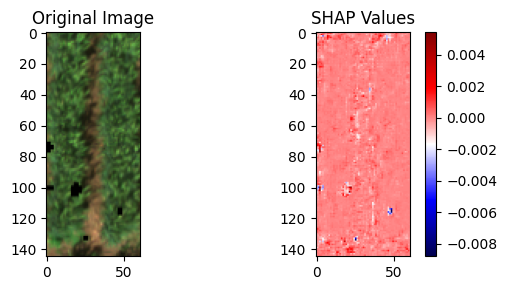

(145, 61, 8)
(145, 61)


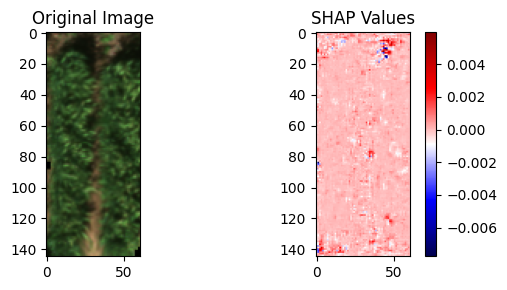

(145, 61, 8)
(145, 61)


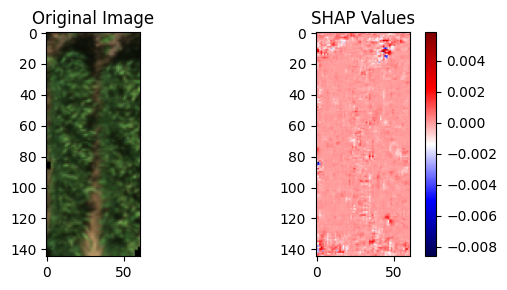

(145, 61, 8)
(145, 61)


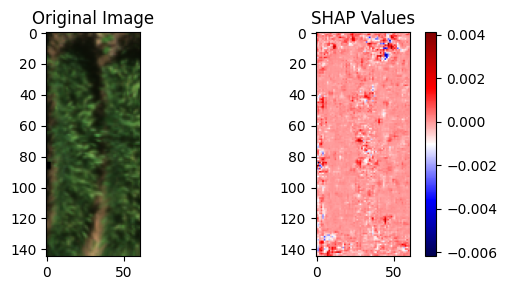

(145, 61, 8)
(145, 61)


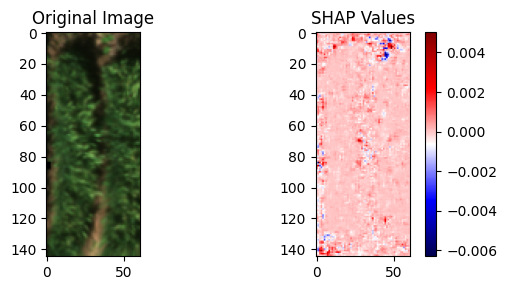

(145, 61, 8)
(145, 61)


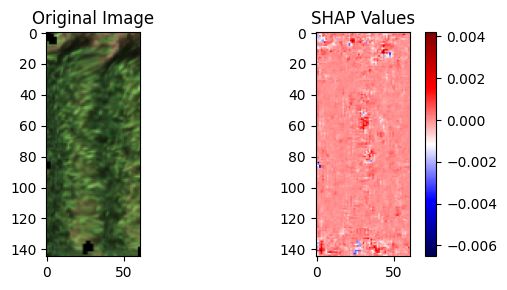

(145, 61, 8)
(145, 61)


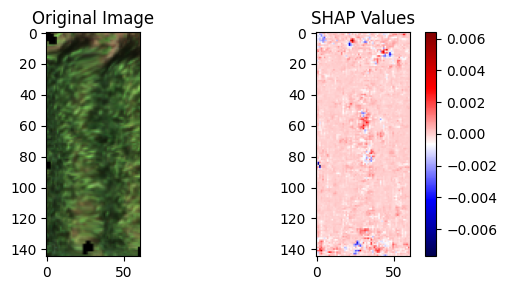

(145, 61, 8)
(145, 61)


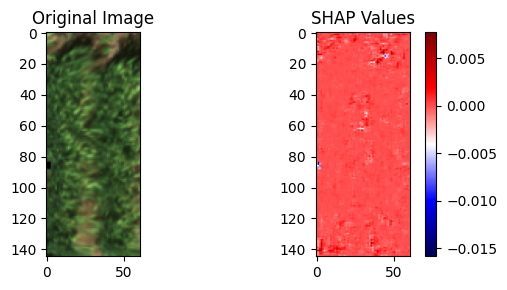

(145, 61, 8)
(145, 61)


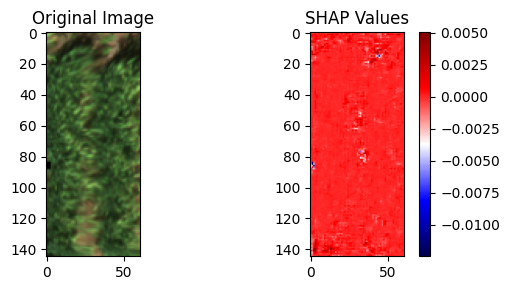

(145, 61, 8)
(145, 61)


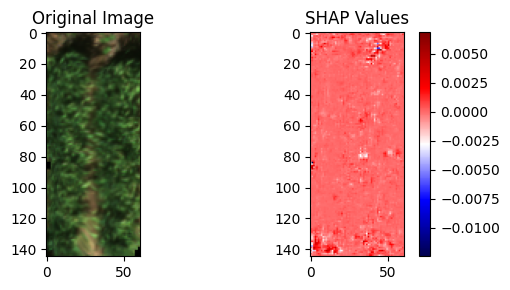

(145, 61, 8)
(145, 61)


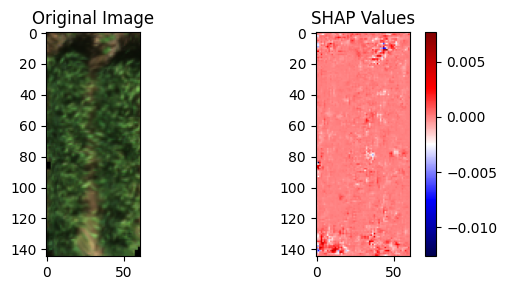

(145, 61, 8)
(145, 61)


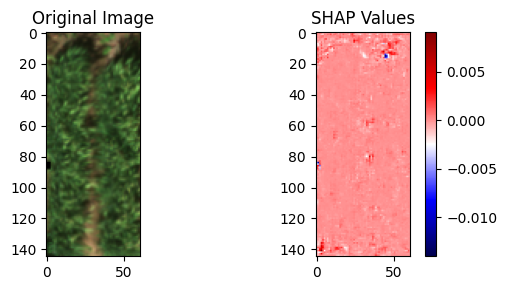

(145, 61, 8)
(145, 61)


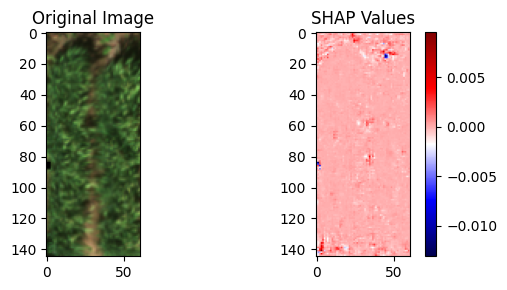

(145, 61, 8)
(145, 61)


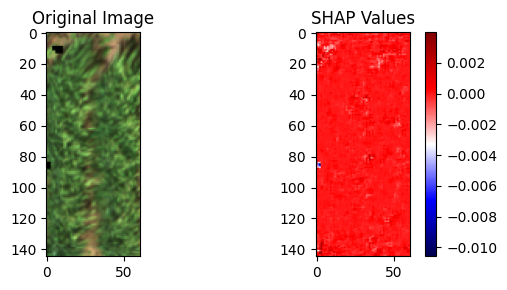

(145, 61, 8)
(145, 61)


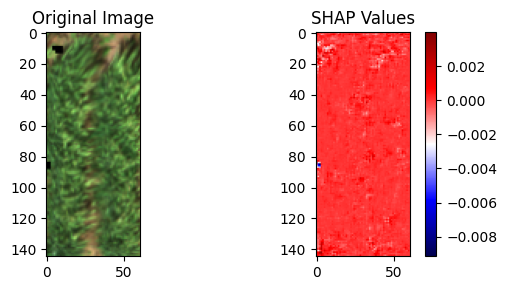

(145, 61, 8)
(145, 61)


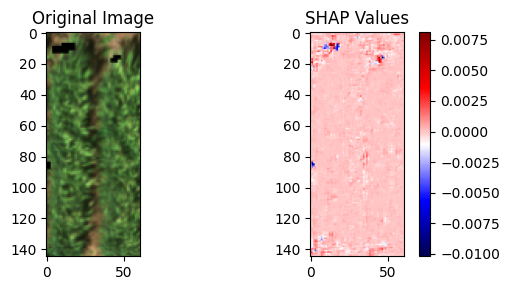

(145, 61, 8)
(145, 61)


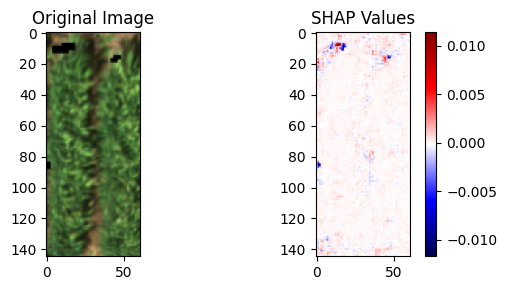

(145, 61, 8)
(145, 61)


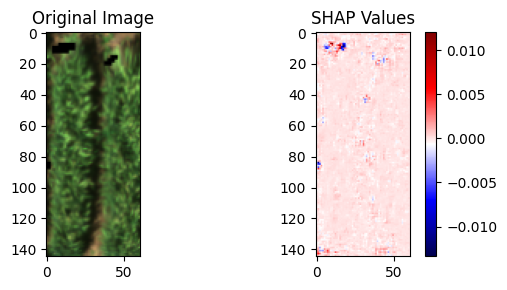

(145, 61, 8)
(145, 61)


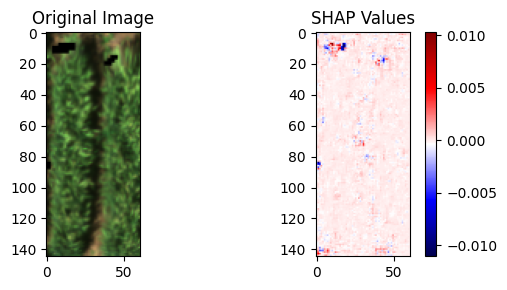

(145, 61, 8)
(145, 61)


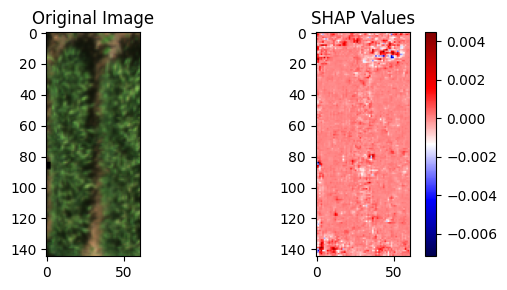

(145, 61, 8)
(145, 61)


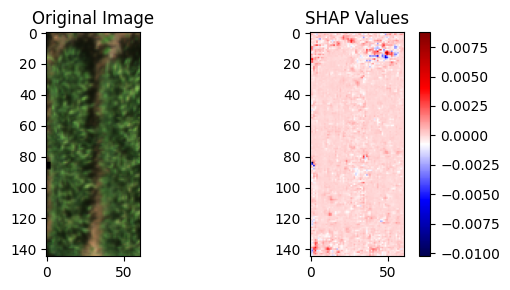

(145, 61, 8)
(145, 61)


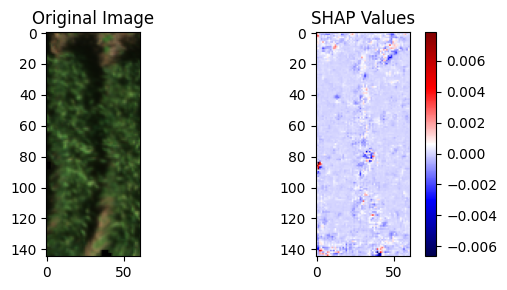

(145, 61, 8)
(145, 61)


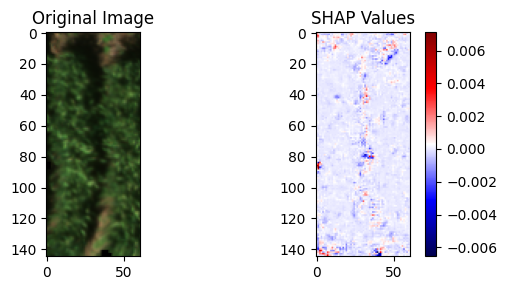

(145, 61, 8)
(145, 61)


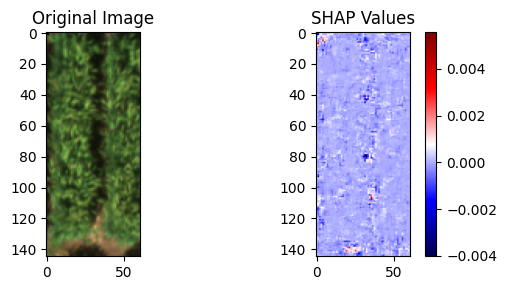

(145, 61, 8)
(145, 61)


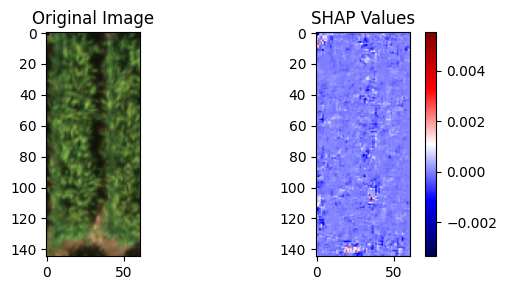

(145, 61, 8)
(145, 61)


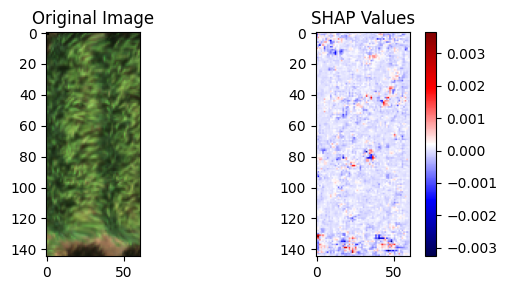

(145, 61, 8)
(145, 61)


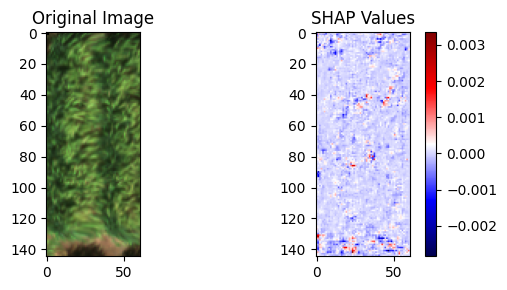

(145, 61, 8)
(145, 61)


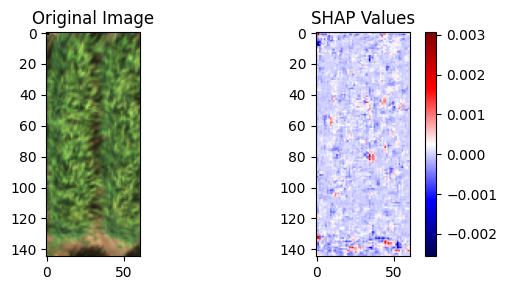

(145, 61, 8)
(145, 61)


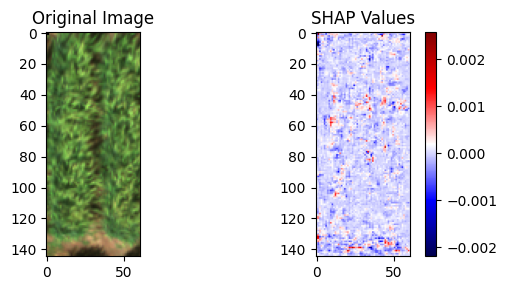

(145, 61, 8)
(145, 61)


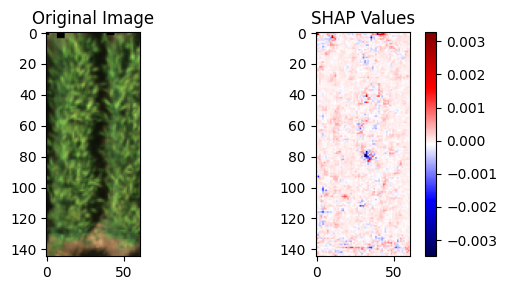

(145, 61, 8)
(145, 61)


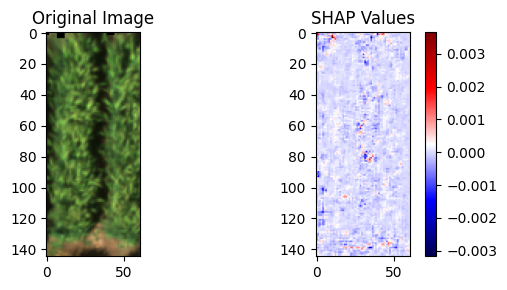

(145, 61, 8)
(145, 61)


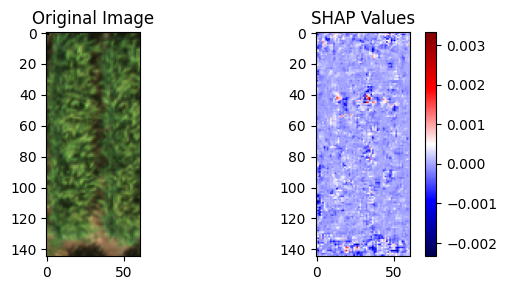

(145, 61, 8)
(145, 61)


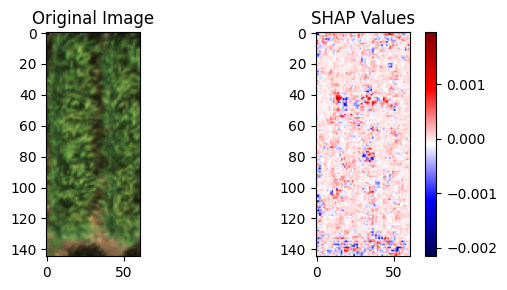

In [20]:
import matplotlib.pyplot as plt

shap_values_img = shap_values[0]

for i in range(40):
    image = test_imgs[i, :, :, :3]
    shap_vals = shap_values_img[i][:, :, :, 0]
    print(shap_vals.shape)
    
    # Sum SHAP across channels for visualization (or pick one band)
#    shap_sum = shap_values[0][i,:,:,:]
#    print(shap_sum.shape)
    shap_band = shap_vals[:, :, 5] #last number depicts band
    print(shap_band.shape)
    
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(image)  # normalize if needed
    plt.title("Original Image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(shap_band, cmap='seismic')
    plt.title("SHAP Values")
    plt.colorbar()
    plt.tight_layout()
    plt.show()